In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 读取数据
train_path = 'E:/Datasets/house-prices-advanced-regression-techniques/train.csv'
test_path = 'E:/Datasets/house-prices-advanced-regression-techniques/test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [3]:
# 删除Id属性
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

print(all_features.shape)

(2919, 79)


In [4]:
# 数据预处理
# 连续值标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 离散值处理
all_features = pd.get_dummies(all_features, dummy_na=True)
bool_features = all_features.dtypes[all_features.dtypes == 'bool'].index
all_features[bool_features] = all_features[bool_features].astype('int')

# 转换为tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape([-1, 1]), dtype=torch.float32)

print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

torch.Size([1460, 330])
torch.Size([1459, 330])
torch.Size([1460, 1])


In [5]:
# 定义模型
class MyNet(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(MyNet, self).__init__()
        self.linear1 = nn.Linear(n_inputs, 256)
        self.dropout1 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(256, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.1)
        self.linear4 = nn.Linear(256, n_outputs)
        
        self.apply(self._init_params)
    
    def _init_params(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias, val=0)
    
    def forward(self, X):
        X = self.linear1(X)
        X = torch.relu(X)
        X = self.dropout1(X)
        X = self.linear2(X)
        X = torch.relu(X)
        X = self.dropout2(X)
        X = self.linear3(X)
        X = torch.relu(X)
        X = self.dropout3(X)
        X = self.linear4(X)
        
        return X

mse = nn.MSELoss()
def log_rmse(net, X, y):
    y_hat = net(X)
    y = y.view(y_hat.shape)
    y_hat = torch.clamp(y_hat, 1, float('inf'))
    rmse = torch.sqrt(mse(torch.log(y_hat), torch.log(y)))
    
    return rmse

In [7]:
# 定义训练函数
def train(net, train_features, train_labels, test_features, test_labels, n_epochs, lr, wd, batch_size):
    train_dataset = Data.TensorDataset(train_features, train_labels)
    train_iter = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
    train_losses, test_losses = [], []
    
    for epoch in range(n_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = mse(y_hat, y.view(y_hat.shape)) 
#             l = log_rmse(net, X, y) # 用这个效果很差
            l.backward()
            optimizer.step()
        
        train_loss = log_rmse(net, train_features, train_labels).item()
        train_losses.append(train_loss)
        
        if test_labels is not None:
            test_loss = log_rmse(net, test_features, test_labels).item()
            test_losses.append(test_loss)
            
    return train_losses, test_losses

In [8]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_cur, y_cur = X[idx, :], y[idx, :]
        
        if i == j:
            X_valid, y_valid = X_cur, y_cur
        elif X_train is None:
            X_train, y_train = X_cur, y_cur
        else:
            X_train = torch.cat([X_train, X_cur], 0)
            y_train = torch.cat([y_train, y_cur], 0)
        
    return X_train, y_train, X_valid, y_valid

def k_fold(k, n_inputs, n_outputs, train_features, train_labels, n_epochs, lr, wd, batch_size):
    train_loss_sum, test_loss_sum = 0.0, 0.0
    
    for i in range(k):
        data = get_k_fold_data(k, i, train_features, train_labels)
        
        net = MyNet(n_inputs, n_outputs)
        
        train_losses, test_losses = train(net, *data, n_epochs, lr, wd, batch_size)
        
        train_loss_sum += train_losses[-1]
        test_loss_sum += test_losses[-1]
        
        if i == 0:
            fig, ax = plt.subplots(figsize=[5, 2.5])
            ax.set_xlabel('epoch')
            ax.set_ylabel('log rmse')
            ax.set_yscale('log')
            ax.grid(True)
            ax.plot(range(1, n_epochs + 1), train_losses, c='b', label='train')
            ax.plot(range(1, n_epochs + 1), test_losses, c='g', linestyle='--', label='test')
            
            plt.legend()
            plt.show()
            
        print(f'fold {i + 1: d}, train log rmse {train_losses[-1]: .4f}, test log rmse {test_losses[-1]: .4f}')
    
    print(f'\n{k: d}-fold: mean train log rmse {train_loss_sum / k: .4f}, mean test log rmse {test_loss_sum / k: .4f}')
    

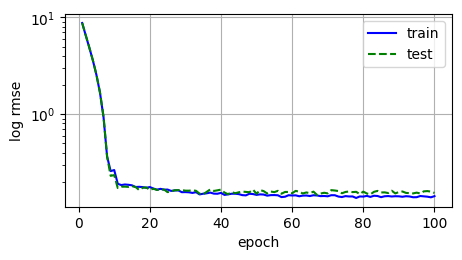

fold  1, train log rmse  0.1415, test log rmse  0.1529
fold  2, train log rmse  0.1335, test log rmse  0.1642
fold  3, train log rmse  0.1348, test log rmse  0.1633
fold  4, train log rmse  0.1396, test log rmse  0.1500
fold  5, train log rmse  0.1295, test log rmse  0.1728

 5-fold: mean train log rmse  0.1358, mean test log rmse  0.1606


In [10]:
k = 5
n_inputs, n_outputs = train_features.shape[1], 1
n_epochs, batch_size = 100, 128
lr, wd = 0.001, 0.01

k_fold(k, n_inputs, n_outputs, train_features, train_labels, n_epochs, lr, wd, batch_size)

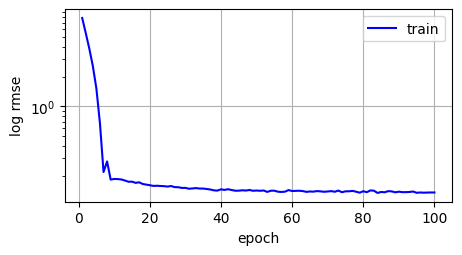

train log rmse  0.1354


In [12]:
# 训练
n_inputs, n_outputs = train_features.shape[1], 1
n_epochs, batch_size = 100, 128
lr, wd = 0.001, 0.01

net = MyNet(n_inputs, n_outputs)

train_losses, _ = train(net, train_features, train_labels, None, None, n_epochs, lr, wd, batch_size)

fig, ax = plt.subplots(figsize=[5, 2.5])
ax.set_xlabel('epoch')
ax.set_ylabel('log rmse')
ax.set_yscale('log')
ax.grid(True)
ax.plot(range(1, n_epochs + 1), train_losses, c='b', label='train')

plt.legend()
plt.show()
    
print(f'train log rmse {train_losses[-1]: .4f}')

In [20]:
# 预测
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.flatten())
submission = pd.concat((test_data['Id'], test_data['SalePrice']), axis=1)
submission.to_csv('submission.csv', index=False)